In [1]:
from dptb.postprocess.bandstructure.band import Band
from dptb.nn.nnsk import NNSK
from dptb.utils.tools import j_loader
from dptb.nn.build import build_model
import os
from dptb.postprocess.bandstructure.band import Band
from dptb.nn.nnsk import NNSK
from dptb.utils.tools import j_loader
from dptb.nn.build import build_model
import os
from dptb.nn.dftbsk import DFTBSK
from dptb.nn.deeptb import MIX
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
import torch
import matplotlib.pyplot as plt
import numpy as np
from dptb.utils.tools import get_neighbours


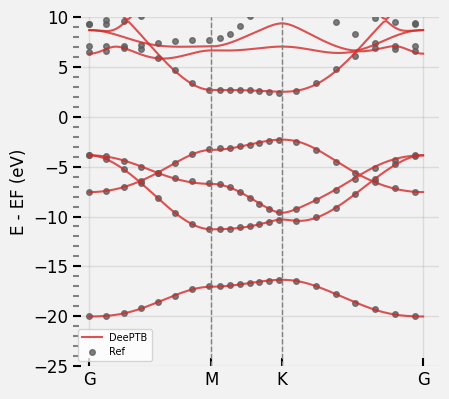

In [187]:
from dptb.nn.build import build_model
from dptb.utils.tools import j_loader
from dptb.postprocess.bandstructure.band import Band


model = build_model(checkpoint="./nnsk/checkpoint/nnsk.best.pth")
jdata = j_loader("./run/band.json")
results_path = "./band_plot"
kpath_kwargs = jdata["task_options"]
stru_data = "./data/struct.vasp"
AtomicData_options = {"r_max": 5.0,"er_max": 3.5, "oer_max":1.6, "pbc": True}

bcal = Band(model=model, 
            use_gui=False, 
            results_path='./', 
            device=model.device)
eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = kpath_kwargs["ref_band"],
               E_fermi = -7,
               emin = -25,
               emax = 10)


In [4]:
# build data from structure:
structase = read(stru_data)
data = AtomicData.from_ase(structase, **AtomicData_options)
data = AtomicData.to_AtomicDataDict(data)
data = model.idp(data)
model.transform = False
data = model(data)

In [16]:
model.idp_sk.skonsitetype_maps

{'s': slice(0, 1, None), 'p': slice(1, 2, None)}

In [17]:
data['node_features']

tensor([[-17.5307,  -9.3161],
        [ -5.5234,  -4.1026]], grad_fn=<AddBackward0>)

In [19]:
data['edge_features'].shape

torch.Size([48, 4])

In [34]:
rij = data[AtomicDataDict.EDGE_LENGTH_KEY]
rij = rij.numpy()
edge_index = data[AtomicDataDict.EDGE_TYPE_KEY].flatten()
bond_neighbor = get_neighbours(structase,cutoff=10,thr=1e-3)

In [127]:
skink_dict={}
for ibtype in model.idp_sk.bond_types:
    skink_dict[ibtype] = {}
    tol= 0.05
    # if ibtype.split("-")[0] != ibtype.split("-")[1]:
    bond_nn = np.array(bond_neighbor[ibtype]) if ibtype in bond_neighbor else np.array(bond_neighbor[ibtype.split("-")[1]+"-"+ibtype.split("-")[0]])
    ibond_idx = model.idp_sk.bond_to_type[ibtype]
    r_idx = (edge_index == ibond_idx).numpy()

    bond_nn_in  = bond_nn[bond_nn < max(rij[r_idx]) + 2 * tol]
    for ii in range(len(bond_nn_in)):
        idis = bond_nn_in[ii]
        r_indx_nn = (rij > idis - tol)*(rij < idis + tol)
        r_idx_all = r_idx * r_indx_nn
        skink_dict[ibtype][str(ii+1)+'-nn'] = {}
        skink_dict[ibtype][str(ii+1)+'-nn']['rij'] = rij[r_idx_all]
        skink_dict[ibtype][str(ii+1)+'-nn']['skints']  = data['edge_features'][r_idx_all].detach().numpy()

B:
    1s  : -17.53071p  :  -9.3161
N:
    1s  :  -5.52341p  :  -4.1026


In [177]:
print("><><"*30)
print("Onsite Energy:")
for itype in model.idp_sk.type_names:
    iaid = (model.idp_sk.chemical_symbol_to_type[itype])
    onsiteEs = data['node_features'][iaid].detach().numpy()
    print(itype+":\n    ",end="")
    for ikey in model.idp_sk.skonsite_maps.keys():
        ikeyslice = model.idp_sk.skonsite_maps[ikey]
        onsiteEs[ikeyslice]
        print(f"{ikey:3s} : {onsiteEs[ikeyslice][0]:8.4f}",end="")
    print()
print("<><>"*30)

print("SK integrals:")
skbondname = {0:'sigma',1:'pi',2:'delta'}
for ikey in skink_dict.keys():
    skink_dict[ikey]
    print(ikey+":")
    for innkey in skink_dict[ikey].keys():
        rij_mean = np.mean(skink_dict[ikey][innkey]['rij'])

        #innkey_print_str = "    "+innkey +':\n    '
        innkey_print_str = "    "+innkey

        print(f"{innkey_print_str} : {rij_mean:6.4f}\n    ",end="")

        skints_mean = np.mean(skink_dict[ikey][innkey]['skints'],axis=0)

        for iorbp in model.idp_sk.orbpair_maps.keys():
            values = skints_mean[model.idp_sk.orbpair_maps[iorbp]]

            for ivv in range(len(values)):
                skbond_print_str ="    "+iorbp+'-'+skbondname[ivv]
                print(f"{skbond_print_str:12} : {values[ivv]:8.4f} ", end=" ")
        print()
print("><><"*30)

    

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Onsite Energy:
B:
    1s  : -17.53071p  :  -9.3161
N:
    1s  :  -5.52341p  :  -4.1026
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
SK integrals:
B-B:
    1-nn : 2.5040
        1s-1s-sigma :  -0.7322      1s-1p-sigma :  -0.0058      1p-1p-sigma :   0.9666      1p-1p-pi :   0.4556  
    2-nn : 4.3371
        1s-1s-sigma :  -0.0800      1s-1p-sigma :  -0.0023      1p-1p-sigma :   0.0247      1p-1p-pi :   0.1622  
B-N:
    1-nn : 1.4457
        1s-1s-sigma :  -3.9776      1s-1p-sigma :   5.3327      1p-1p-sigma :  -3.7027      1p-1p-pi :   2.6170  
    2-nn : 2.8914
        1s-1s-sigma :  -0.1688      1s-1p-sigma :   0.6508      1p-1p-sigma :  -0.6945      1p-1p-pi :   0.1494  
    3-nn : 3.8249
        1s-1s-sigma :  -0.0456      1s-1p-sigma :   0.2693      1p-1p-sigma :  -0.3419      1p-1p-pi 

B
    s : -17.5307
    p : -9.3161
N
    s : -5.5234
    p : -4.1026


In [145]:
onsiteEs[ikeyslice]

array([-4.102643], dtype=float32)